In [1]:
# For importing utils
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from utils import PERTURBATIONS

/nlp/scr/kallini/miniconda3/envs/llmenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_geometric_mean_perplexities(ax_i, ax, file_info, title, checkpoints, seeds, pos_encodings, warmup):
    
    nps = "" if pos_encodings else "_no_positional_encodings"
    wp = "_warmup" if warmup else ""

    results_path = 'perplexity_results{}/{}_100M{}/randinit_seed{}_test_{}.csv'

    for file_data in file_info:
        model_perturb, test_perturb, marker, linestyle, legend_name = file_data

        all_seeds_gmeans = []
        for seed in seeds:
            df = pd.read_csv(results_path.format(wp, model_perturb, nps, seed, test_perturb))
            gmeans = []

            # Calculate geometric means for each checkpoint
            for ckpt in checkpoints:
                gmeans.append(stats.gmean(df[f"Perplexities (ckpt {ckpt})"]))

            all_seeds_gmeans.append(gmeans)

        all_seeds_gmeans = np.array(all_seeds_gmeans)
        means = np.mean(all_seeds_gmeans, axis=0)

        ci = None
        if len(seeds) > 1:
            sems = stats.sem(all_seeds_gmeans, axis=0)
            # Calculate confidence interval using t-distribution
            ci_lower, ci_upper = stats.t.interval(0.95, df=len(seeds)-1,
                                                loc=means, scale=sems)
            ci = (ci_upper - ci_lower) / 2

        # Plotting
        ax.errorbar(checkpoints, means, ci, marker=marker, 
                    color=PERTURBATIONS[test_perturb]["color"],
                    linestyle=linestyle, label=legend_name)

    ax.set_title(title)
    if ax_i == 0:
        ax.set_ylabel("Geometric Mean Perplexity", fontsize=12)
    
    if not pos_encodings and title == "*Shuffle":
        ax.legend(fontsize=6)
    elif title == "*Shuffle":
        ax.legend(fontsize=8, framealpha=1)
    else:
        ax.legend(fontsize=9, framealpha=1)
    ax.grid(True, color="lightgray")

In [4]:
def plot_perplexities_grouped(file_infos, titles, checkpoints, seeds, pos_encodings=True, warmup=False):
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(1, len(file_infos), figsize=(16, 5), sharey=False, sharex=True)
    fig.subplots_adjust(wspace=0.15)
    fig.supxlabel("Training Steps", fontsize=12)
    
    axs_flat = axs.flatten()
    
    # Call individual plot function with different parameters for each subplot
    for i, (file_info, title) in enumerate(zip(file_infos, titles)):
        plot_geometric_mean_perplexities(
            i, axs_flat[i], file_info, title, checkpoints, seeds, pos_encodings, warmup)

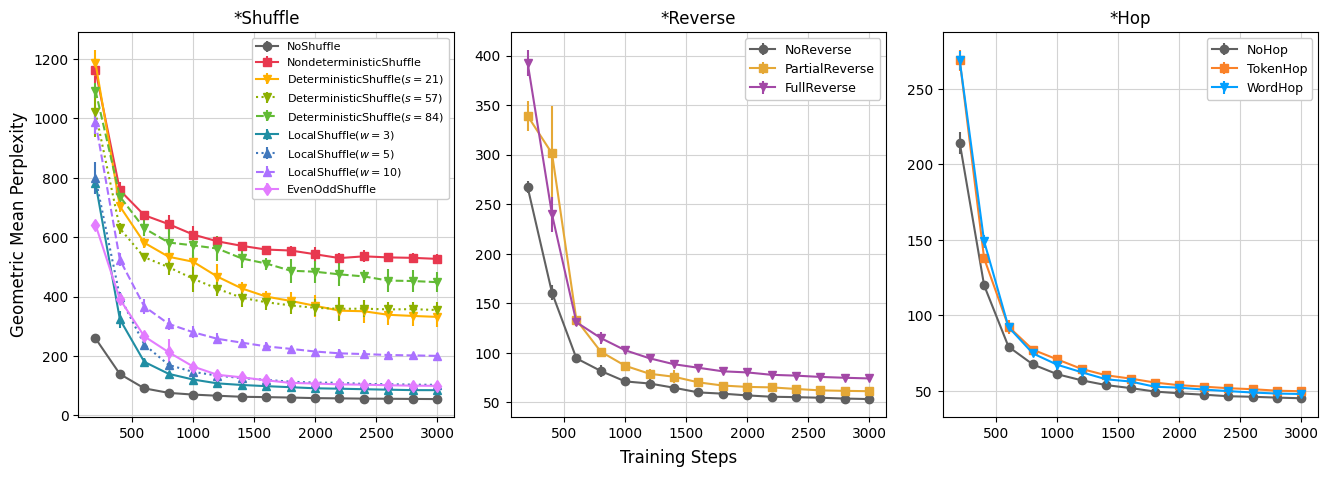

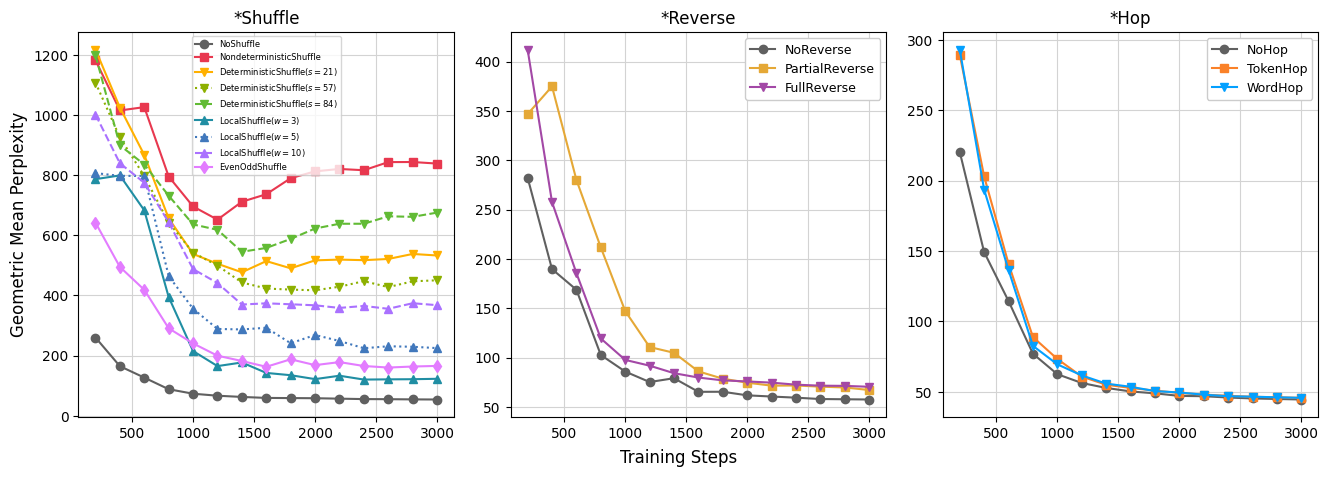

In [5]:
MAX_TRAINING_STEPS = 3000
CHECKPOINTS = list(range(200, MAX_TRAINING_STEPS+1, 200))
SEEDS = [0, 14, 41, 53, 96]


shuffle_file_info = [
    ("shuffle_control", "shuffle_control", 'o', "-", 'NoShuffle'),
    ("shuffle_nondeterministic", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle'),
    ("shuffle_deterministic21", "shuffle_deterministic21", "v", "-", 'DeterministicShuffle$(s=21)$'),
    ("shuffle_deterministic57", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$'),
    ("shuffle_deterministic84", "shuffle_deterministic84", "v", "--", 'DeterministicShuffle$(s=84)$'),
    ("shuffle_local3", "shuffle_local3", "^", "-", 'LocalShuffle$(w=3)$'),
    ("shuffle_local5", "shuffle_local5", "^", ":", 'LocalShuffle$(w=5)$'),
    ("shuffle_local10", "shuffle_local10", "^", "--", 'LocalShuffle$(w=10)$'),
    ("shuffle_even_odd", "shuffle_even_odd", "d", "-", 'EvenOddShuffle'),
]
reverse_file_info = [
    ("reverse_control", "reverse_control", 'o', "-", 'NoReverse'),
    ("reverse_partial", "reverse_partial", "s", "-", 'PartialReverse'),
    ("reverse_full", "reverse_full", 'v', "-", 'FullReverse'),
]
hop_file_info = [
    ("hop_control", "hop_control", 'o', "-", 'NoHop'),
    ("hop_tokens4", "hop_tokens4", "s", "-", 'TokenHop'),
    ("hop_words4", "hop_words4", 'v', "-", 'WordHop'),
]

# Plot
plot_perplexities_grouped([shuffle_file_info, reverse_file_info, hop_file_info], 
                          ["*Shuffle", "*Reverse", "*Hop"],
                          CHECKPOINTS, SEEDS)
plt.savefig("figures/perplexities.pdf", format="pdf", bbox_inches="tight")

# No Pos Encodings
plot_perplexities_grouped([shuffle_file_info, reverse_file_info, hop_file_info], 
                          ["*Shuffle", "*Reverse", "*Hop"],
                          CHECKPOINTS, [53], pos_encodings=False)
plt.savefig("figures/perplexities_no_pos_encodings.pdf", format="pdf", bbox_inches="tight")

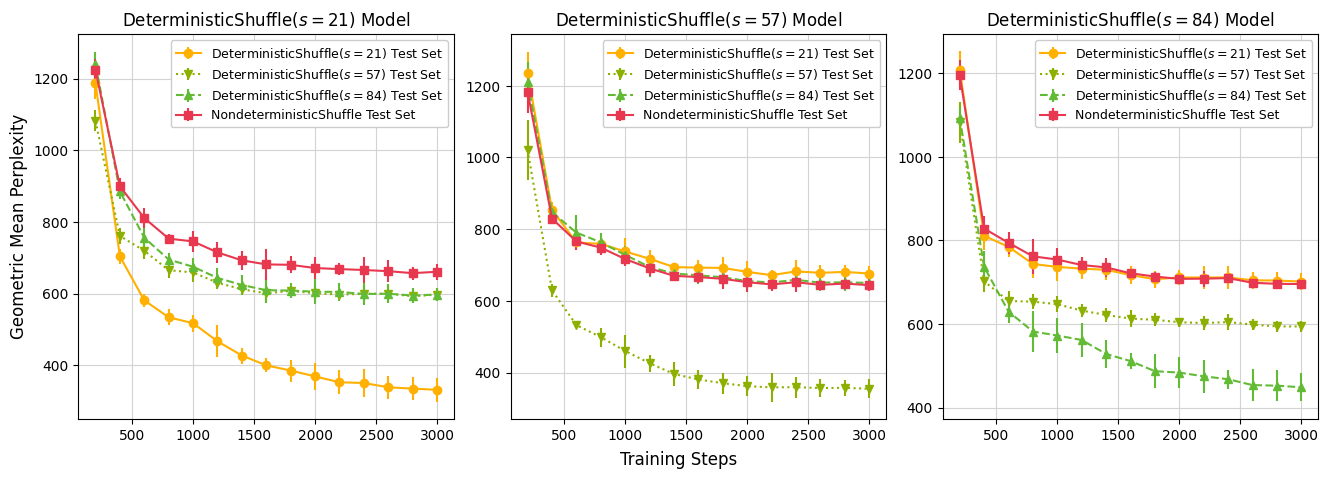

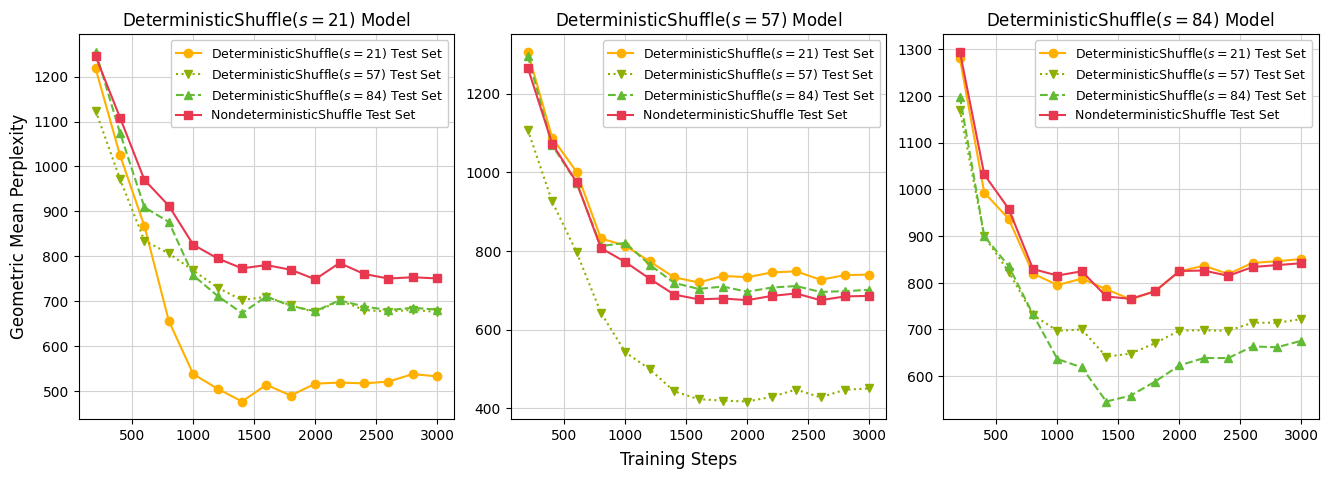

In [6]:
shuffle21_file_info = [
    ("shuffle_deterministic21", "shuffle_deterministic21", "o", "-", 'DeterministicShuffle$(s=21)$ Test Set'),
    ("shuffle_deterministic21", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$ Test Set'),
    ("shuffle_deterministic21", "shuffle_deterministic84", "^", "--", 'DeterministicShuffle$(s=84)$ Test Set'),
    ("shuffle_deterministic21", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle Test Set'),
]
shuffle57_file_info = [
    ("shuffle_deterministic57", "shuffle_deterministic21", "o", "-", 'DeterministicShuffle$(s=21)$ Test Set'),
    ("shuffle_deterministic57", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$ Test Set'),
    ("shuffle_deterministic57", "shuffle_deterministic84", "^", "--", 'DeterministicShuffle$(s=84)$ Test Set'),
    ("shuffle_deterministic57", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle Test Set'),
]
shuffle84_file_info = [
    ("shuffle_deterministic84", "shuffle_deterministic21", "o", "-", 'DeterministicShuffle$(s=21)$ Test Set'),
    ("shuffle_deterministic84", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$ Test Set'),
    ("shuffle_deterministic84", "shuffle_deterministic84", "^", "--", 'DeterministicShuffle$(s=84)$ Test Set'),
    ("shuffle_deterministic84", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle Test Set'),
]

# Plot
plot_perplexities_grouped([shuffle21_file_info, shuffle57_file_info, shuffle84_file_info], 
                          ["DeterministicShuffle$(s=21)$ Model", "DeterministicShuffle$(s=57)$ Model",
                           "DeterministicShuffle$(s=84)$ Model"],
                          CHECKPOINTS, SEEDS)
plt.savefig("figures/perplexities_deterministic_shuffle.pdf", format="pdf", bbox_inches="tight")

# No Pos Encodings
plot_perplexities_grouped([shuffle21_file_info, shuffle57_file_info, shuffle84_file_info], 
                          ["DeterministicShuffle$(s=21)$ Model", "DeterministicShuffle$(s=57)$ Model",
                           "DeterministicShuffle$(s=84)$ Model"],
                          CHECKPOINTS, [53], pos_encodings=False)
plt.savefig("figures/perplexities_deterministic_shuffle_no_pos_encodings.pdf", format="pdf", bbox_inches="tight")

## Results with different warm-up hyperparameters

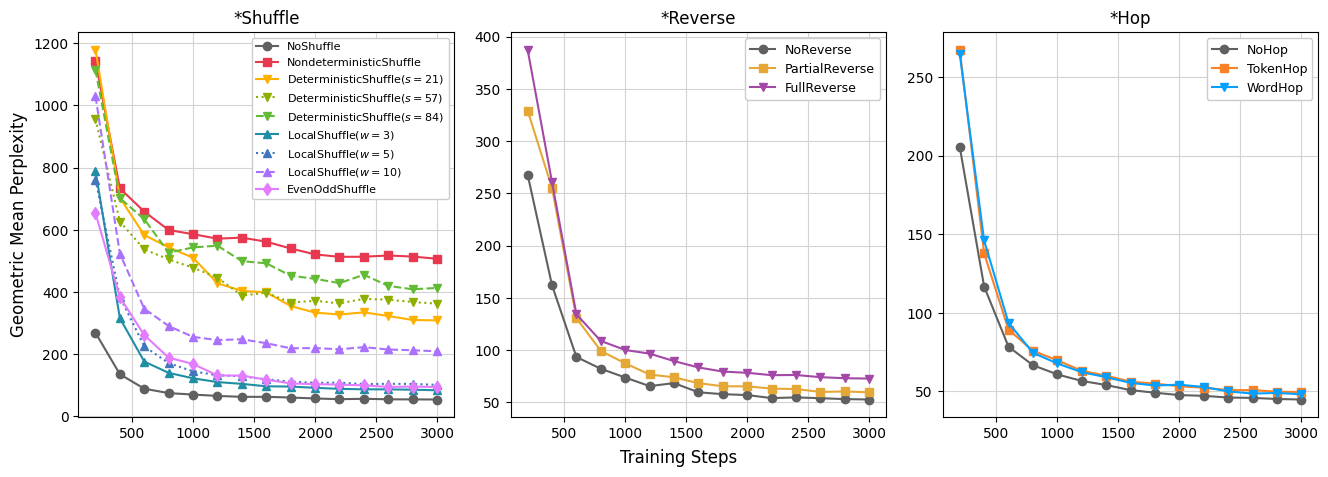

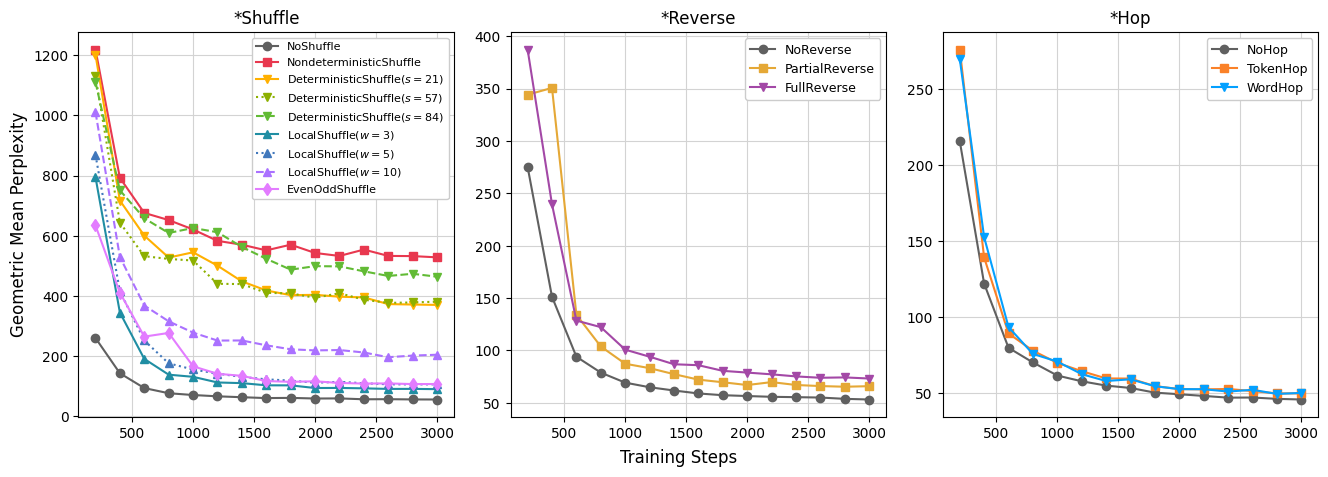

In [7]:
MAX_TRAINING_STEPS = 3000
CHECKPOINTS = list(range(200, MAX_TRAINING_STEPS+1, 200))


shuffle_file_info = [
    ("shuffle_control", "shuffle_control", 'o', "-", 'NoShuffle'),
    ("shuffle_nondeterministic", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle'),
    ("shuffle_deterministic21", "shuffle_deterministic21", "v", "-", 'DeterministicShuffle$(s=21)$'),
    ("shuffle_deterministic57", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$'),
    ("shuffle_deterministic84", "shuffle_deterministic84", "v", "--", 'DeterministicShuffle$(s=84)$'),
    ("shuffle_local3", "shuffle_local3", "^", "-", 'LocalShuffle$(w=3)$'),
    ("shuffle_local5", "shuffle_local5", "^", ":", 'LocalShuffle$(w=5)$'),
    ("shuffle_local10", "shuffle_local10", "^", "--", 'LocalShuffle$(w=10)$'),
    ("shuffle_even_odd", "shuffle_even_odd", "d", "-", 'EvenOddShuffle'),
]
reverse_file_info = [
    ("reverse_control", "reverse_control", 'o', "-", 'NoReverse'),
    ("reverse_partial", "reverse_partial", "s", "-", 'PartialReverse'),
    ("reverse_full", "reverse_full", 'v', "-", 'FullReverse'),
]
hop_file_info = [
    ("hop_control", "hop_control", 'o', "-", 'NoHop'),
    ("hop_tokens4", "hop_tokens4", "s", "-", 'TokenHop'),
    ("hop_words4", "hop_words4", 'v', "-", 'WordHop'),
]

# Plot
plot_perplexities_grouped([shuffle_file_info, reverse_file_info, hop_file_info], 
                          ["*Shuffle", "*Reverse", "*Hop"],
                          CHECKPOINTS, [96])
plt.savefig("figures/perplexities_warmup1000.pdf", format="pdf", bbox_inches="tight")

plot_perplexities_grouped([shuffle_file_info, reverse_file_info, hop_file_info], 
                          ["*Shuffle", "*Reverse", "*Hop"],
                          CHECKPOINTS, [0])
plt.savefig("figures/perplexities_warmup4000.pdf", format="pdf", bbox_inches="tight")